In [7]:
import yfinance as yf

stocks = ['BTC-USD', 'ETH-USD']

data = yf.download(stocks, period='2y')

[*********************100%***********************]  2 of 2 completed


In [8]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # Matriz do fechamento de preços diários
absdiff = np.diff(closes)                   # Mudança no fechamento de preços diários
reldiff = np.divide(absdiff, closes[:,:-1]) # mudança relativa no fechamento de preços
delta = np.mean(reldiff, axis=1)            # média do fechamento de preços
sigma = np.cov(reldiff)                     # covariancia (devios padrão)
std = np.std(reldiff, axis=1)               # desvio padrão

In [9]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Criar um modelo vazio
m = gp.Model('portfolio')

# Criar uma matriz para as açòes
x = m.addMVar(len(stocks))

# O objetivo é minimizar o risco (ao quadrado).  Isso é modelado usando
# a matriz de covariância, que mede a correlação histórica entre as ações
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fixar o orçamento com uma constante
m.addConstr(x.sum() == 1, 'budget')

# Verificar a formulação do modelo
m.write('portfolio_selection_optimization.lp')

# Otimizar o modelo para reduzir o risco
m.optimize()

Set parameter Username

--------------------------------------------
--------------------------------------------

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0xa696e05f
Model has 3 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros
Presolved model has 3 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.

In [10]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
BTC-USD,9.999995e-01
ETH-USD,5.289790e-07
Volatility,3.717121e-02
Expected Return,-6.393955e-05


In [11]:
# Criar uma expressão representando o retorno esperado do portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Resolver para plotar uma fronteira de eficiência, variando os retornos
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target[0].rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x5f34520d
Model has 3 quadratic objective terms
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-05, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros
Presolved model has 3 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95355156e+05 -1.95355156e+05  2.00e+03 4.42e-02  1.00e+06     0s
   1   1.96736853e-01 -6.26217215e+01  2.00e+00 4.

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95360244e+05 -1.95360244e+05  2.00e+03 4.52e-02  1.00e+06     0s
   1   1.96801381e-01 -6.26262298e+01  1.97e+00 4.46e-05  1.02e+03     0s
   2   1.47426459e-03 -5.75463639e+01  1.97e-06 4.46e-11  2.88e+01     0s
   3   1.47425957e-03 -5.61292107e-02  1.97e-12 4.86e-17  2.88e-02     0s
   4   1.47425957e-03  1.41659856e-03  3.47e-18 1.60e-16  2.88e-05     0s
   5   1.47425957e-03  1.47420185e-03  0.00e+00 6.94e-18  2.89e-08     0s
   6   1.47425957e-03  1.47425952e-03  0.00e+00 6.94e-18  2.89e-11     0s

Barrier solved model in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.47425957e-03

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xfdc331fa
Model 

Optimal objective 1.63431411e-03

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xa53839b1
Model has 3 quadratic objective terms
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 2 columns, 4 nonzeros
Presolved model has 3 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95366349e+05 -1.95366349e+05  2.00e+03 4.63e-02  1.00e+06     0s
   1   1.9688046

 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95371436e+05 -1.95371436e+05  2.00e+03 4.72e-02  1.00e+06     0s
   1   2.05164365e-01 -6.26357074e+01  1.96e+00 4.62e-05  1.01e+03     0s
   2   1.91548704e-03 -5.83046129e+01  1.96e-06 4.62e-11  2.92e+01     0s
   3   1.91547110e-03 -5.64474641e-02  1.96e-12 4.86e-17  2.92e-02     0s
   4   1.91547110e-03  1.85704986e-03  1.39e-17 0.00e+00  2.92e-05     0s
   5   1.91547110e-03  1.91541262e-03  0.00e+00 6.94e-18  2.92e-08     0s
   6   1.91547110e-03  1.91547104e-03  6.94e-18 0.00e+00  2.93e-11     0s

Barrier solved model in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.91547110e-03

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 


Barrier solved model in 6 iterations and 0.03 seconds (0.00 work units)
Optimal objective 2.22401156e-03

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xcfb85ee6
Model has 3 quadratic objective terms
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 6e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros
Presolved model has 3 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95377541

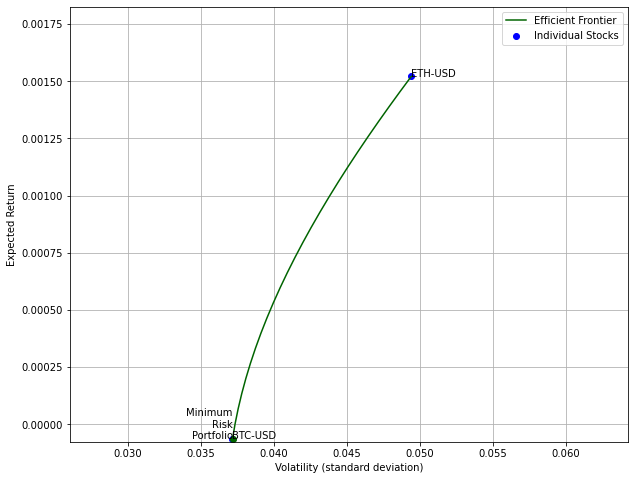

In [12]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plotar volatilidade x retorno esperado para cada ação
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plotar volatilidade x retorno esperado para o portfolio como um todo
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plotar a fronteira de eficiência
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Formatar e plotar a figura final
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()